In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import to_hex
from matplotlib import ticker
import seaborn as sns
import shap
import joblib
from glob import glob
from sklearn.inspection import partial_dependence

import sys
sys.path.append("../scripts")
from experiments import load_split, PROTECTED_ATTRIBUTES

from credit_pipeline import training, evaluate
from credit_pipeline.training import EBE # small fix to be able to load models
from credit_pipeline.training import ks_threshold
%load_ext autoreload
%autoreload 2


2024-06-26 09:49:42.815719: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-26 09:49:42.850619: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-26 09:49:42.850639: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-26 09:49:42.851748: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-26 09:49:42.857562: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-26 09:49:42.858255: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
os.makedirs("explainability_data", exist_ok = True)

In [3]:
def parallel_coordinates(
    df,
    columns,
    columns_ranges = None,
    columns_tick_format = None,
    columns_names = None,
    color_column = None,
    color_mapper = None,
    name_mapper = None,
    legend_order = None,
    title = None
):
    """
    Simple parallel coordinates to plot the projection results.
    """
    norm_df = df.copy() # dataframe will be normalized

    fig, axes = plt.subplots(1, len(columns)-1, sharey=False, figsize=(15,5))

    if columns_ranges is None:
        columns_ranges = [None for _ in columns]

    if columns_tick_format is None:
        columns_tick_format = [None for _ in columns]

    # Get min, max and range for each column
    # Normalize the data for each column
    min_max_range = {}
    for i, col in enumerate(columns):
        if columns_ranges[i] is None:
            col_max = df[col].max()
            col_min = df[col].min()
        else:
            col_max = columns_ranges[i][1]
            col_min = columns_ranges[i][0]

        min_max_range[col] = [col_min, col_max]
        col_range = col_max - col_min
        if col_range == 0:
            col_range = 1
        norm_df[col] = (df[col] - col_min) / col_range

    x = list(range(len(columns)))
    axx = axes[-1].twinx()
    # Plot each row
    if color_column is None:
        for i, ax in enumerate(axes):
            for idx in norm_df.index:
                ax.plot(x, norm_df.loc[idx, columns], c = "blue", lw = 3)
        for idx in norm_df.index:
            axx.plot(x, norm_df.loc[idx, columns], c = "blue", lw = 3)
    else:
        color_values = norm_df[color_column].unique()
        colormap = plt.get_cmap("Paired")
        if color_column is not None and color_mapper is None:
            color_mapper = {color_value: colormap(i) for i, color_value in enumerate(color_values)}

        for ii, value in enumerate(color_values):
            df_value = norm_df[norm_df[color_column] == value]
            for i, ax in enumerate(axes[:-1]):
                for idx in df_value.index:
                    ax.plot(x, df_value.loc[idx, columns], alpha = 0.85, lw = 5, label = value, c = color_mapper[value])
            for idx in df_value.index:
                axx.plot(x, df_value.loc[idx, columns], alpha = 0.85, lw = 5, label = value, c = color_mapper[value])
    
    for i, ax in enumerate(axes):
        ax.set_xlim([x[i], x[i+1]])
        ax.set_ylim([-0.05, 1.05])
        # get yticks from ax
        yticks = ax.get_yticks()
        col_min = min_max_range[columns[i]][0]
        col_max = min_max_range[columns[i]][1]
        col_range = col_max - col_min
        format_ = columns_tick_format[i]
        if format_ is None:
            ax.set_yticklabels([np.round(yi * col_range  + col_min, 1)  for yi in yticks], fontsize = 18)
        else:
            ax.set_yticklabels([format_(yi * col_range  + col_min)  for yi in yticks], fontsize = 18)
        #ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    
    axes[0].set_ylim([-0.05, 1.05])

    for i, ax in enumerate(axes[:-1]):
        ax.xaxis.set_major_locator(ticker.FixedLocator([i]))
        ax.set_xticklabels([columns_names[i]], fontsize = 18, rotation=45)

    axes[-1].xaxis.set_major_locator(ticker.FixedLocator([i+1, i+2]))
    axes[-1].set_xticklabels([columns_names[i+1], columns_names[i+2]], fontsize = 18, rotation = 45)

    # tick for right side of last axis
    yticks = axes[-1].get_yticks()
    col_min = min_max_range[columns[len(axes)]][0]
    col_max = min_max_range[columns[len(axes)]][1]
    col_range = col_max - col_min
    format_ = columns_tick_format[len(axes)]
    if format_ is None:
        axx.set_yticklabels([np.round((yi * col_range +  col_min), 1)  for yi in yticks], fontsize = 18)
    else:
        axx.set_yticklabels([format_(yi * col_range +  col_min)  for yi in yticks], fontsize = 18)
    axx.set_axisbelow(True)
    axx.set_ylim([-0.05, 1.05])
    axx.spines['top'].set_visible(False)
    axx.spines['bottom'].set_visible(False)

    
    if title:
        plt.suptitle(title, y = 1, fontsize = 20)
    # Remove space between subplots
    plt.subplots_adjust(wspace=0)

    if color_column is not None:
        handles = [
            mpatches.Patch(color=to_hex(color_mapper[value]), label=name_mapper[value]) for value in legend_order
        ]
        plt.legend(handles = handles, bbox_to_anchor=(1.3, 1), ncol = len(legend_order))

In [4]:
def parallel_coordinates_vert(
    df,
    columns,
    columns_ranges = None,
    columns_tick_format = None,
    columns_names = None,
    color_column = None,
    color_mapper = None,
    name_mapper = None,
    legend_order = None,
    title = None
):
    """
    Simple parallel coordinates to plot the projection results.
    """
    norm_df = df.copy() # dataframe will be normalized

    fig, axes = plt.subplots(len(columns)-1, 1, sharex=False, figsize=(5,15))

    if columns_ranges is None:
        columns_ranges = [None for _ in columns]
    if columns_tick_format is None:
        columns_tick_format = [lambda x : np.round(x, 1) for _ in columns]

    # Get min, max and range for each column
    # Normalize the data for each column
    min_max_range = {}
    for i, col in enumerate(columns):
        if columns_ranges[i] is None:
            col_max = df[col].max()
            col_min = df[col].min()
        else:
            col_max = columns_ranges[i][1]
            col_min = columns_ranges[i][0]

        min_max_range[col] = [col_min, col_max]
        col_range = col_max - col_min
        if col_range == 0:
            col_range = 1
        norm_df[col] = (df[col] - col_min) / col_range

    # Invert to plot first columns at the top
    x = list(range(len(columns)))[::-1]
    axx = axes[0].twiny()
    # Plot each row
    if color_column is None:
        for i, ax in enumerate(axes):
            for idx in norm_df.index:
                ax.plot(norm_df.loc[idx, columns], x, c = "blue", lw = 3)
        for idx in norm_df.index:
            axx.plot(norm_df.loc[idx, columns], x, c = "blue", lw = 3)
    else:
        color_values = norm_df[color_column].unique()
        colormap = plt.get_cmap("Paired")
        if color_column is not None and color_mapper is None:
            color_mapper = {color_value: colormap(i) for i, color_value in enumerate(color_values)}

        for ii, value in enumerate(color_values):
            df_value = norm_df[norm_df[color_column] == value]
            for i, ax in enumerate(axes[:-1]):
                for idx in df_value.index:
                    ax.plot(df_value.loc[idx, columns], x, alpha = 0.85, lw = 5, label = value, c = color_mapper[value])
            for idx in df_value.index:
                axx.plot(df_value.loc[idx, columns], x, alpha = 0.85, lw = 5, label = value, c = color_mapper[value])
    
    for i, ax in enumerate(axes):
        ax.set_ylim([x[i+1], x[i]])
        ax.set_xlim([-0.05, 1.05])
        xticks = ax.get_xticks()
        col_min = min_max_range[columns[i]][0]
        col_max = min_max_range[columns[i]][1]
        col_range = col_max - col_min
        format_ = columns_tick_format[i]
        ax.set_xticklabels([format_(yi * col_range  + col_min)  for yi in xticks], fontsize = 18)
    
    axes[0].set_xlim([-0.05, 1.05])

    for i, ax in enumerate(axes):
        #ax.yaxis.set_major_locator(ticker.FixedLocator([i+1]))
        ax.set_yticks([len(axes) - i])
        ax.set_yticklabels([columns_names[i]], fontsize = 18)

    axes[-1].set_yticks([0, 1])
    axes[-1].set_yticklabels([columns_names[-2], columns_names[-1]], fontsize = 18)

    # tick for right side of last axis
    axx.set_facecolor("none")
    xticks = axes[-1].get_xticks()
    col_min = min_max_range[columns[len(axes)]][0]
    col_max = min_max_range[columns[len(axes)]][1]
    col_range = col_max - col_min
    format_ = columns_tick_format[len(axes)]
    if format_ is None:
        axx.set_xticklabels([np.round((yi * col_range +  col_min), 1)  for yi in xticks], fontsize = 18)
    else:
        axx.set_xticklabels([format_(yi * col_range +  col_min)  for yi in xticks], fontsize = 18)
    #axx.xaxis.tick_top()
    #axx.set_axisbelow(True)
    #axx.set_xlim([-0.05, 1.05])
    #axx.spines['top'].set_visible(False)
    #axx.spines['bottom'].set_visible(False)

    for ax in list(axes) + [axx]:
        ax.set_facecolor("none")
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)


    
    if title:
        plt.suptitle(title, y = 1, fontsize = 20)
    # Remove space between subplots
    plt.subplots_adjust(hspace=0)

    if color_column is not None:
        handles = [
            mpatches.Patch(color=to_hex(color_mapper[value]), label=name_mapper[value]) for value in legend_order
        ]
        plt.legend(handles = handles, bbox_to_anchor=(1.3, 1), ncol = len(legend_order))

In [5]:
dataset_name = "homecredit"
seed = 0

plot of logistic regression feature importance, gbm feature importance, and shap feature importance of both models

In [68]:
path = "../results/credit_models"
lr_features_importance = []
lgbm_features_importance = []
shap_lr_features_importance = []
shap_lgbm_features_importance = []

background_samples = 1000
n_samples = 50000

for fold in range(10):
    X_train, Y_train, X_val, Y_val, X_test, Y_test = load_split(
        dataset_name, fold, seed
    )
    model = joblib.load(f'{path}/{dataset_name}/{fold}/LogisticRegression.pkl')
    X_train_preprocess = model[:-1].transform(X_train)
    features = X_train_preprocess.columns.tolist()


    categoric_features = model[1].transformers_[1][1].get_feature_names_out()
    categoric_features_mapping = model[1].transformers_[1][1].categories_
    categoric_features_mapping = {f: c for f, c in zip(categoric_features, categoric_features_mapping)}
    
    lr_features_importance.append(model[-1].coef_[0])

    explainer =shap.LinearExplainer(
       model[-1],
        X_train_preprocess.sample(background_samples),
        feature_perturbation="interventional",
    )
    shap_values = explainer(X_train_preprocess.sample(n_samples))
    shap_lr_features_importance.append(np.abs(shap_values.values).mean(0))

    model = joblib.load(f'{path}/{dataset_name}/{fold}/LGBMClassifier.pkl')
    lgbm_features_importance.append(model[-1].feature_importances_ / sum(model[-1].feature_importances_))

    explainer = shap.TreeExplainer(
        model[-1],
        X_train_preprocess.sample(background_samples),
        model_output="probability",
        feature_perturbation="interventional",
        
    )
    shap_values = explainer(X_train_preprocess.sample(n_samples))
    shap_lgbm_features_importance.append(np.abs(shap_values.values).mean(0))
   

lr_features_importance = np.array(lr_features_importance)
lgbm_features_importance = np.array(lgbm_features_importance)
shap_lr_features_importance = np.array(shap_lr_features_importance)
shap_lgbm_features_importance = np.array(shap_lgbm_features_importance)

 69%|==============      | 34476/50000 [08:03<03:37]       

In [ ]:
path = "../results/credit_models"
lr_features_importance = []
lgbm_features_importance = []
shap_lr_features_importance = []
shap_lgbm_features_importance = []

background_samples = 20
n_samples = 100


def wrap_pred_func(model, X, Y):
    Y_score = model.predict_proba(X)[:, 1]
    threshold = ks_threshold(Y, Y_score)
    def pred(X):
        score = model.predict_proba(X)[:, 1]
        return (score > threshold).astype("float")
    return pred

for fold in range(10):
    X_train, Y_train, X_val, Y_val, X_test, Y_test = load_split(
        dataset_name, fold, seed
    )
    model = joblib.load(f'{path}/{dataset_name}/{fold}/LogisticRegression.pkl')
    X_train_preprocess = model[:-1].transform(X_train)
    features = X_train_preprocess.columns.tolist()


    categoric_features = model[1].transformers_[1][1].get_feature_names_out()
    categoric_features_mapping = model[1].transformers_[1][1].categories_
    categoric_features_mapping = {f: c for f, c in zip(categoric_features, categoric_features_mapping)}
    
    lr_features_importance.append(model[-1].coef_[0])

    explainer =shap.LinearExplainer(
        model[-1],
        X_train_preprocess.sample(background_samples),
        feature_perturbation="interventional",
    )
    shap_values = explainer(X_train_preprocess.sample(n_samples))
    shap_lr_features_importance.append(np.abs(shap_values.values).mean(0))

    model = joblib.load(f'{path}/{dataset_name}/{fold}/LGBMClassifier.pkl')
    lgbm_features_importance.append(model[-1].feature_importances_ / sum(model[-1].feature_importances_))
    X_train_preprocess = model[:-1].transform(X_train)

    explainer = shap.KernelExplainer(
        model = wrap_pred_func(model[-1], X_train_preprocess, Y_train),
        #data = X_train_preprocess.sample(background_samples), 
        data = shap.sample(X_train_preprocess, background_samples)
    )
    # explainer = shap.TreeExplainer(
    #     model[-1],
    #     X_train_preprocess.sample(background_samples),
    #     model_output="probability",
    #     feature_perturbation="interventional",
        
    # )
    shap_values = explainer(X_train_preprocess.sample(n_samples))
    shap_lgbm_features_importance.append(np.abs(shap_values.values).mean(0))
   

lr_features_importance = np.array(lr_features_importance)
lgbm_features_importance = np.array(lgbm_features_importance)
shap_lr_features_importance = np.array(shap_lr_features_importance)
shap_lgbm_features_importance = np.array(shap_lgbm_features_importance)

In [129]:
lr_features_importance = pd.DataFrame(
    data = lr_features_importance,
    columns=features
)
lgbm_features_importance = pd.DataFrame(
    data = lgbm_features_importance,
    columns=features
)
shap_lr_features_importance = pd.DataFrame(
    data = shap_lr_features_importance,
    columns=features
)
shap_lgbm_features_importance = pd.DataFrame(
    data = shap_lgbm_features_importance,
    columns=features
)

In [ ]:
lr_features_importance.to_csv("explainability_data/lr_features_importance.csv", index = False)
lgbm_features_importance.to_csv("explainability_data/lgbm_features_importance.csv", index = False)
shap_lr_features_importance.to_csv("explainability_data/shap_lr_features_importance.csv", index = False)
shap_lgbm_features_importance.to_csv("explainability_data/shap_lgbm_features_importance.csv", index = False)

In [6]:
lr_features_importance = pd.read_csv("explainability_data/lr_features_importance.csv")
lgbm_features_importance = pd.read_csv("explainability_data/lgbm_features_importance.csv")
shap_lr_features_importance = pd.read_csv("explainability_data/shap_lr_features_importance.csv")
shap_lgbm_features_importance = pd.read_csv("explainability_data/shap_lgbm_features_importance.csv")

In [7]:
def filter_importance_features(df_importance):
    """Get the median (abs) importance of each feature and select the 10 featuers with highest median importance."""
    importance_values = df_importance.values
    median_importance = np.median(np.abs(importance_values), axis=0)
    sorted_idx = np.argsort(median_importance)[::-1][:10]
    features = df_importance.columns.tolist()
    features_sorted = np.array(features)[sorted_idx]
    return features_sorted

## Global Importances

In [8]:
def plot_pc_importances(df_importance, title = ""):
    features = filter_importance_features(df_importance).tolist()
    n_f = len(features)
    imp_range = [
        df_importance[features].values.min(), df_importance[features].values.max()
    ]
    parallel_coordinates_vert(
        df_importance,
        features,
        columns_ranges = [imp_range for _ in range(n_f)],
        columns_tick_format = None,
        columns_names = features,
        color_column = None,
        color_mapper = None,
        name_mapper = dict([(i, str(i)) for i in range(n_f)]),
        legend_order = None,
        title = title
    )

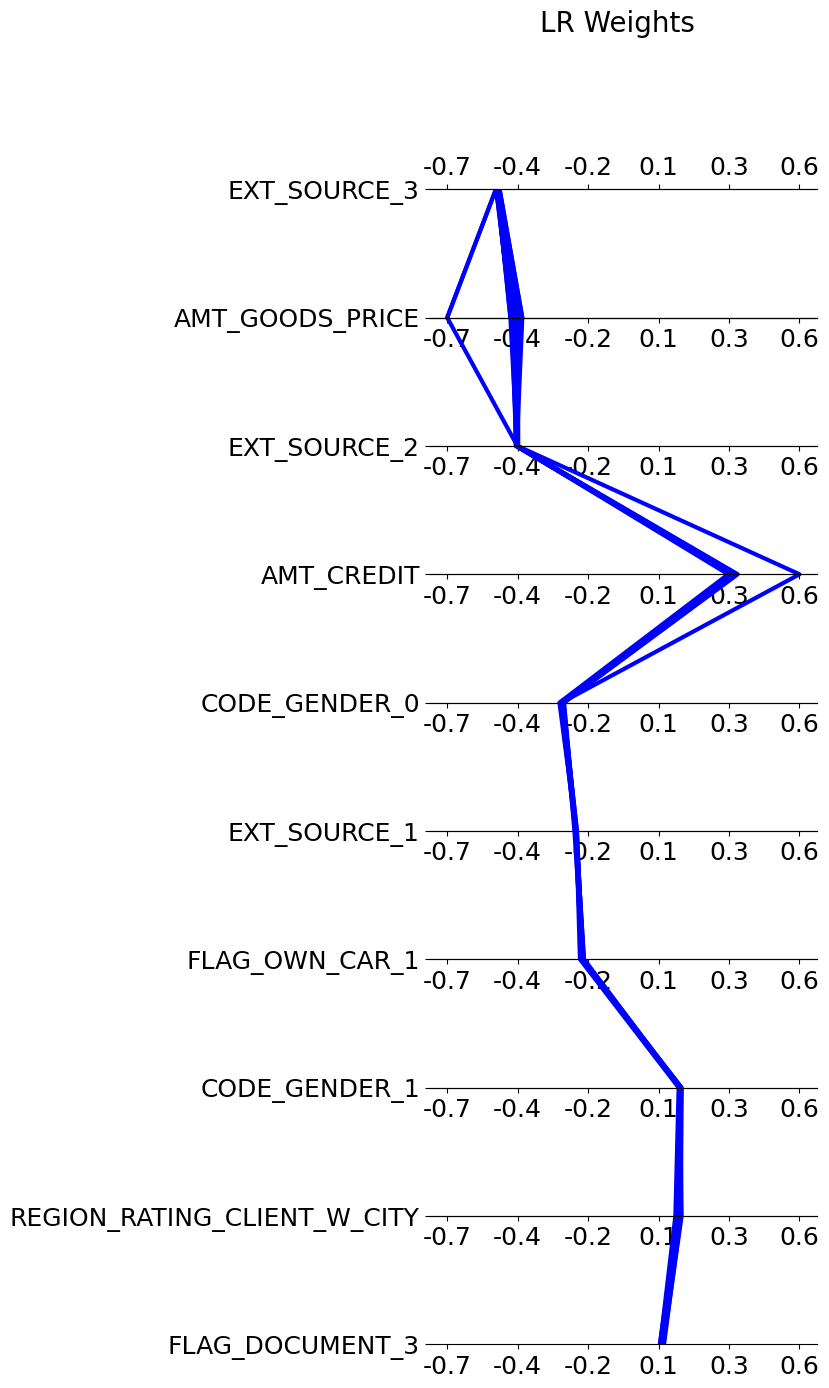

In [9]:
plot_pc_importances(lr_features_importance, "LR Weights")

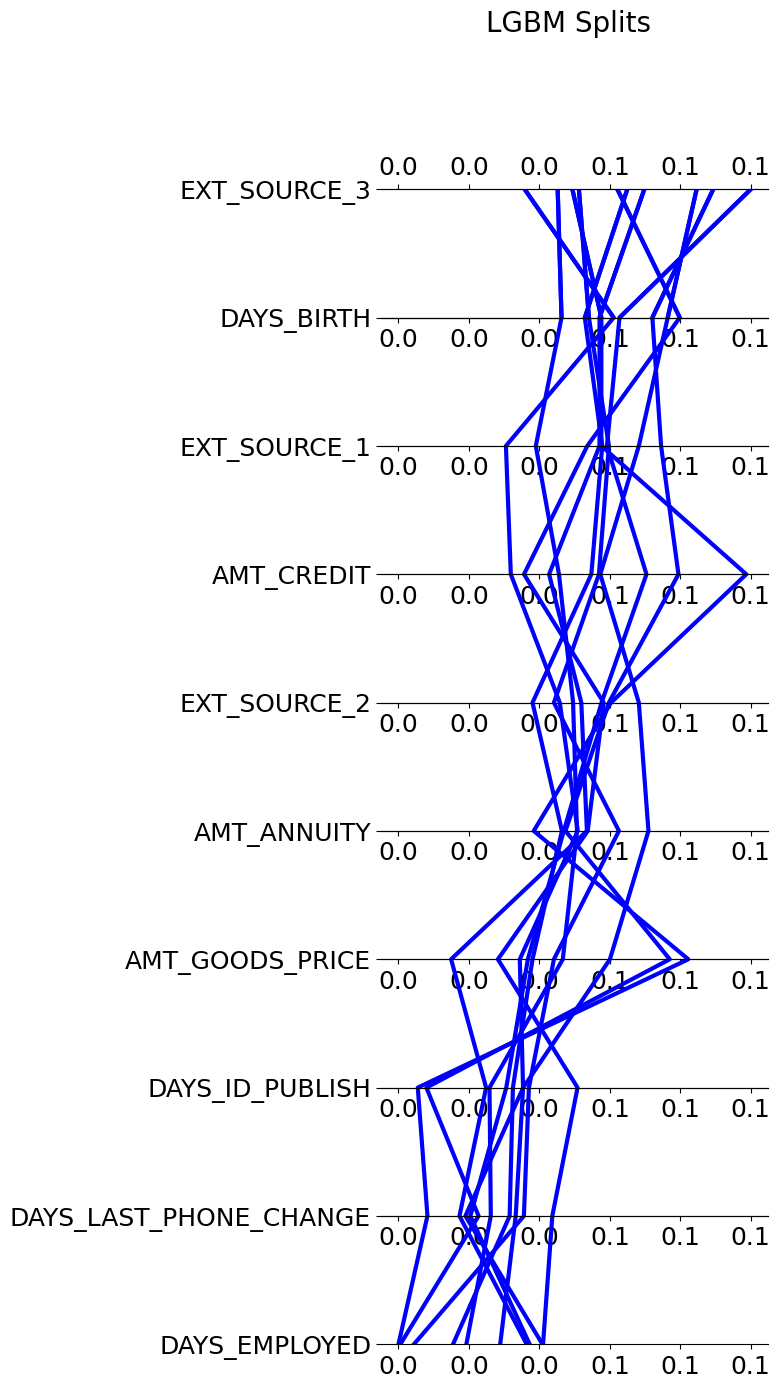

In [10]:
plot_pc_importances(lgbm_features_importance, "LGBM Splits")

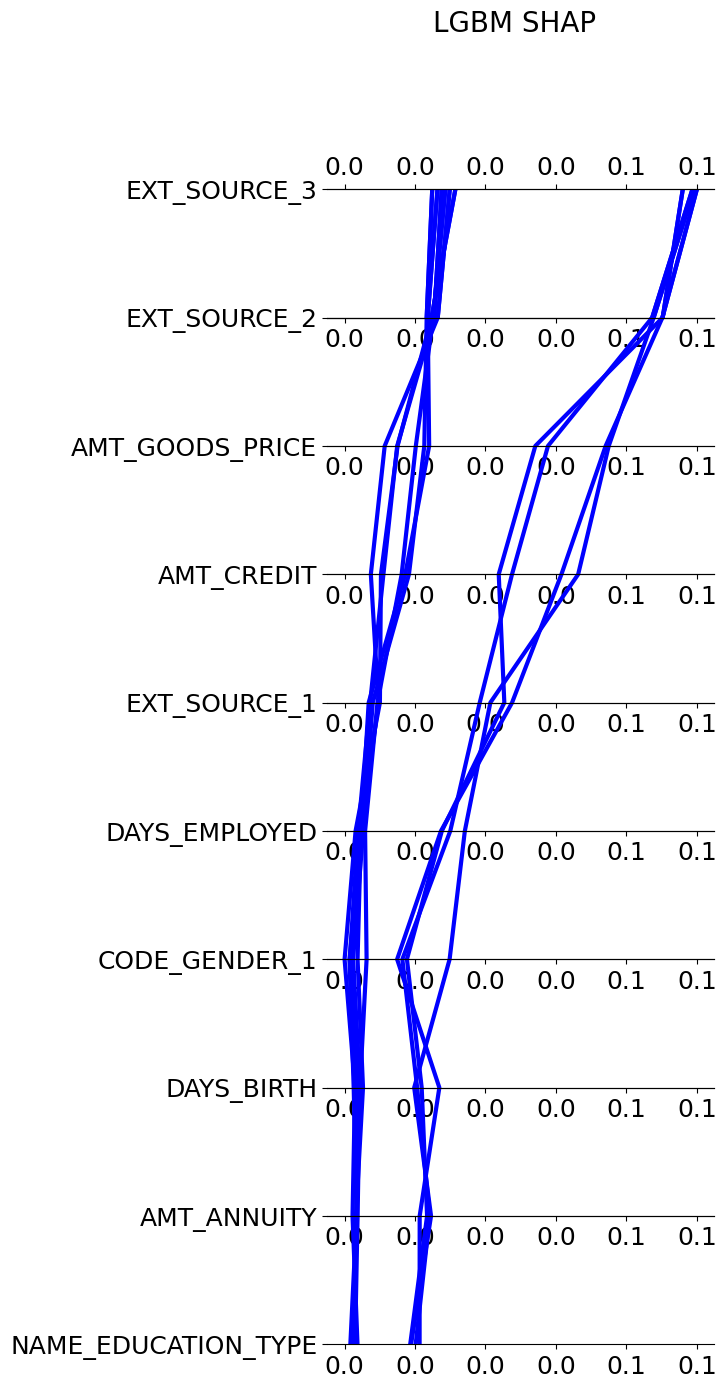

In [11]:
plot_pc_importances(shap_lgbm_features_importance, "LGBM SHAP")

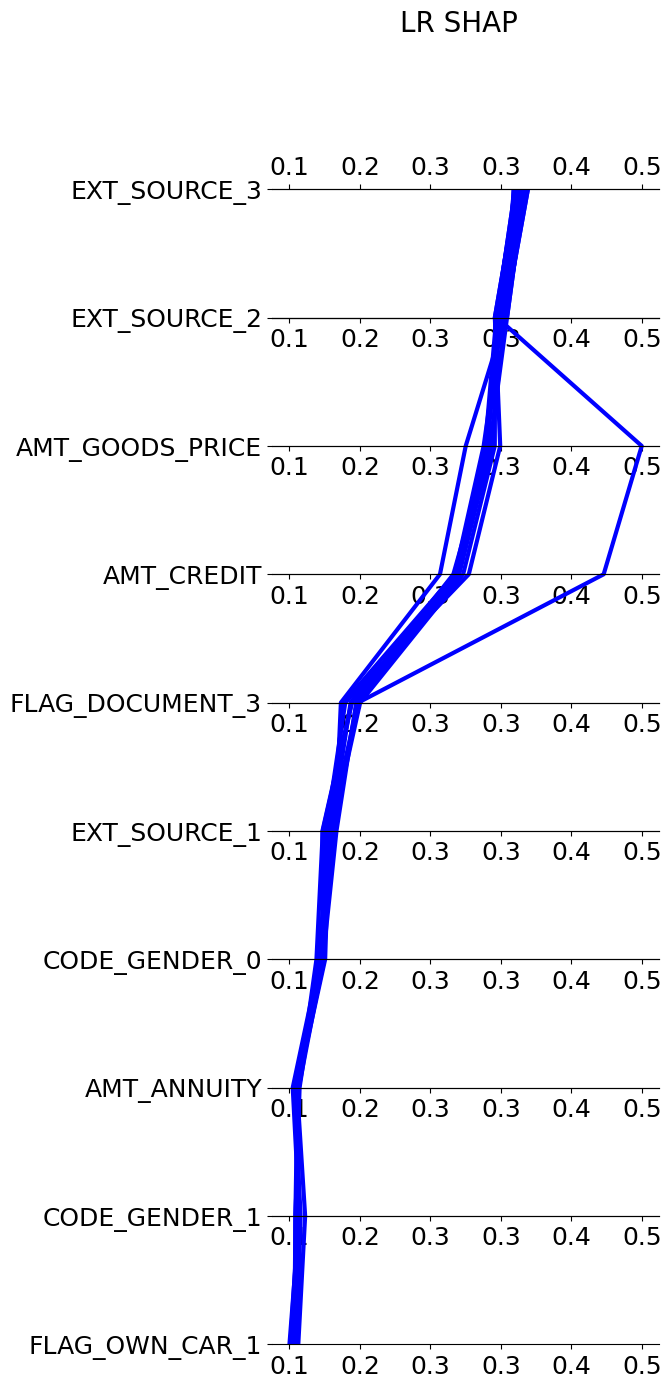

In [12]:
plot_pc_importances(shap_lr_features_importance, "LR SHAP")

## PDP

In [138]:
selected_fold = 0
X_train, Y_train, X_val, Y_val, X_test, Y_test = load_split(
    dataset_name, selected_fold, seed
)

In [139]:
model_list = [
    joblib.load(f'../results/credit_models/{dataset_name}/{selected_fold}/{model_name}.pkl')
    for model_name in ["LogisticRegression", "LGBMClassifier", "RandomForestClassifier"]
]

In [142]:
def partial_dependence_pipeline(model, X, Y, selected_feature, grid_resolution = 50):
    X_sample = X.sample(100, random_state = seed)
    X_preprocess = model[:-1].transform(X_sample)
    pdp = partial_dependence(model[-1], X_preprocess, features = [selected_feature], grid_resolution=grid_resolution, percentiles=(0.05, 0.95), method="brute")

    # Transform back scale
    scaled_features = model[2].transformers_[0][2]
    if selected_feature in scaled_features:
        scale_idx = scaled_features.index(selected_feature)
        scaler = model[2].transformers_[0][1]
        mu = scaler.mean_[scale_idx]
        sigma = scaler.scale_[scale_idx]
        pdp["values"][0] = pdp["values"][0] *sigma + mu 
    return {
        "values" : pdp["values"][0],
        "average" : pdp["average"][0],
    }

In [143]:
def plot_pdp(model_list, X, Y, selected_feature):
    fig, axs = plt.subplots(nrows = 1, ncols = len(model_list), figsize = (10, 4))
    for i, model in enumerate(model_list):
        pdp = partial_dependence_pipeline(model, X, Y, selected_feature)
        axs[i].plot(pdp["values"], pdp["average"])
        axs[i].set_title(model[-1].__class__.__name__)
        axs[i].set_xlabel(selected_feature)
        axs[i].set_ylabel("Prob")
    plt.tight_layout()
    plt.show()

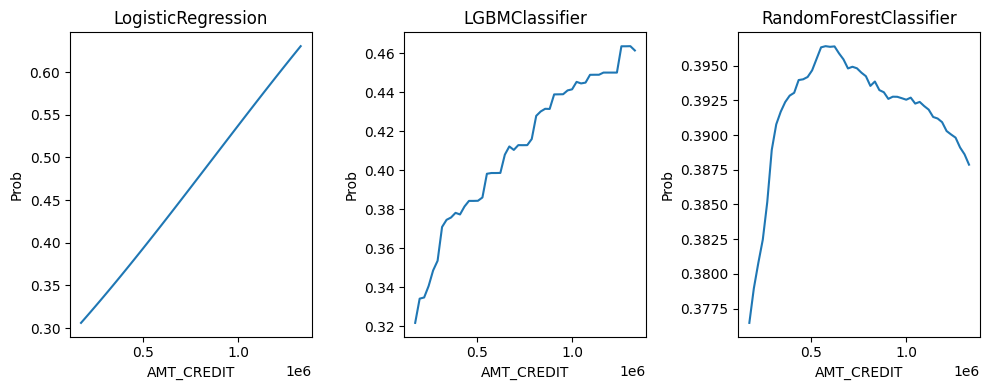

In [144]:
plot_pdp(model_list, X_train, Y_train, "AMT_CREDIT")

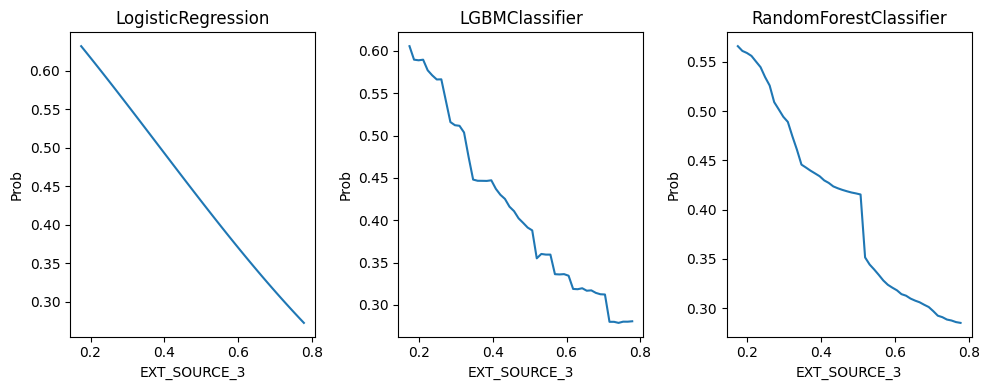

In [102]:
plot_pdp(model_list, X_train, Y_train, "EXT_SOURCE_3")

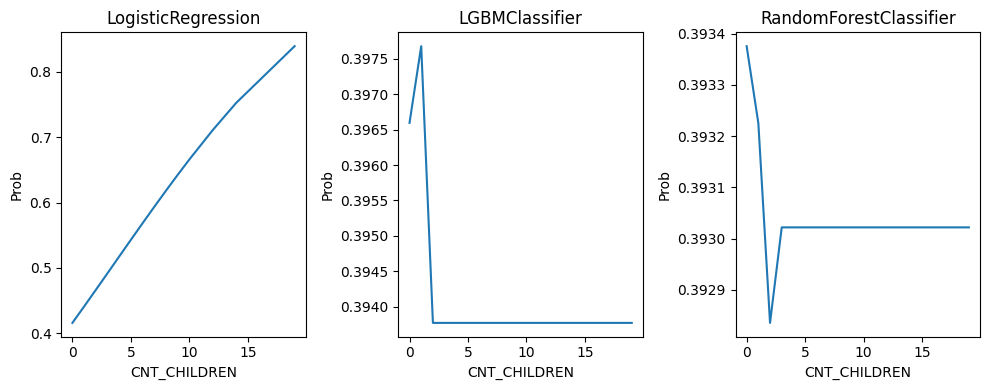

In [103]:
plot_pdp(model_list, X_train, Y_train, "CNT_CHILDREN")

## ICE

In [104]:
selected_fold = 0
X_train, Y_train, X_val, Y_val, X_test, Y_test = load_split(
    dataset_name, selected_fold, seed
)

In [105]:
model_list = [
    joblib.load(f'../results/credit_models/{dataset_name}/{selected_fold}/{model_name}.pkl')
    for model_name in ["LogisticRegression", "LGBMClassifier", "RandomForestClassifier"]
]

In [135]:
def ICE_pipeline(model, X, Y, selected_feature, grid_resolution = 50):
    X_sample = X.sample(100, random_state = seed)
    X_preprocess = model[:-1].transform(X_sample)
    pdp = partial_dependence(model[-1], X_preprocess, features = [selected_feature], grid_resolution=grid_resolution, percentiles=(0.05, 0.95), method="brute", kind = "individual")

    # Transform back scale
    scaled_features = model[2].transformers_[0][2]
    if selected_feature in scaled_features:
        scale_idx = scaled_features.index(selected_feature)
        scaler = model[2].transformers_[0][1]
        mu = scaler.mean_[scale_idx]
        sigma = scaler.scale_[scale_idx]
        pdp["values"][0] = pdp["values"][0] *sigma + mu 
    return {
        "values" : pdp["values"][0],
        "individual" : pdp["individual"][0, :, :],
        "data" : X_sample
    }

In [145]:
def plot_ice(model_list, X, Y, selected_feature):
    fig, axs = plt.subplots(nrows = 1, ncols = len(model_list), figsize = (10, 4))

    color_code = {
        "M" : "blue",
        "F" : "red",
        "XNA": "yellow"
    }
    
    for i, model in enumerate(model_list):
        pdp = ICE_pipeline(model, X, Y, selected_feature)

        for j in range(len(pdp["data"])):
            axs[i].plot(pdp["values"], pdp["individual"][j, :], color_code[pdp["data"].CODE_GENDER.values[j]], alpha = 0.25)
        axs[i].set_title(model[-1].__class__.__name__)
        axs[i].set_xlabel(selected_feature)
        axs[i].set_ylabel("Prob")
    plt.tight_layout()
    plt.show()

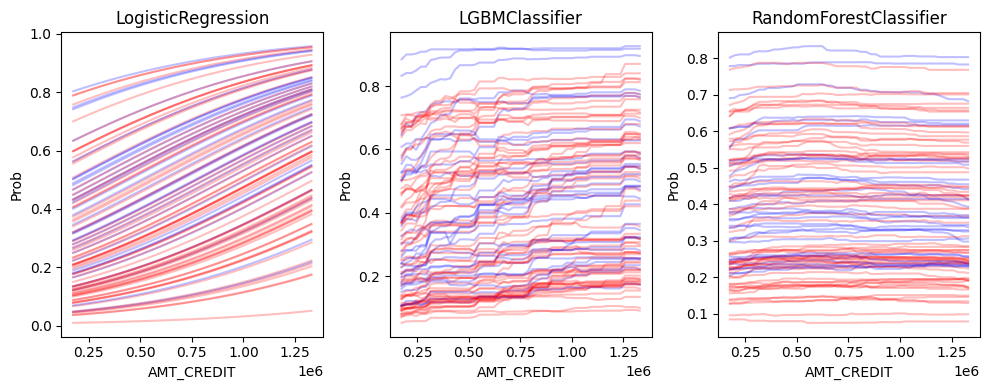

In [146]:
plot_ice(model_list, X_train, Y_train, "AMT_CREDIT")

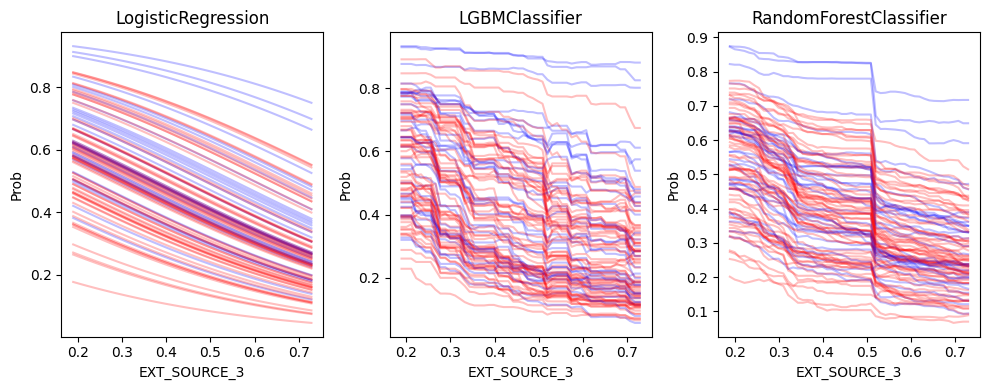

In [147]:
plot_ice(model_list, X_train, Y_train, "EXT_SOURCE_3")

## SHAP and LIME

In [149]:
model = joblib.load(f"../results/credit_models/{dataset_name}/{selected_fold}/MLPClassifier.pkl")
X_train_preprocess = model[:-1].transform(X_train.sample(100, random_state = seed))

In [159]:
exp = shap.Explainer(
    lambda x : model[-1].predict_proba(x)[:, 1],
    masker = X_train_preprocess,
    algorithm = "permutation",
)

In [166]:
explanation = exp(X_train_preprocess.iloc[[0]])

In [183]:
explanation.values[0]

array([ 7.85080204e-05,  2.81331735e-05, -4.06565863e-03, -3.37519849e-03,
        0.00000000e+00,  2.26135509e-03,  2.24936022e-03, -3.44732321e-04,
       -1.38169657e-04,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -2.47155263e-03,  2.73937744e-04,
        3.60569338e-02,  6.87105092e-03, -4.31668015e-02,  1.06655849e-03,
        2.39686122e-03,  6.76497571e-03, -6.98986035e-04, -3.96081482e-03,
        4.03107490e-04,  0.00000000e+00, -4.20293280e-03, -1.33568961e-03,
        0.00000000e+00, -3.67677174e-03,  2.58930406e-05,  1.06309326e-03,
        3.26655616e-04, -2.53224580e-04,  9.57577431e-05,  2.62249783e-04,
       -2.77294142e-04,  2.22311264e-04, -6.02778350e-04, -2.79273076e-04,
        1.71594218e-04, -5.10747346e-03, -1.47543631e-02, -2.29010086e-02,
        1.58415302e-04,  9.18306941e-04,  4.05368389e-05,  2.04294220e-04,
        1.29901288e-04,  1.10603867e-04,  5.20236447e-05,  9.08093626e-05,
       -2.89300125e-05, -

In [1]:
importances = explanation.values[0]
feature_names = X_train_preprocess.columns.tolist()

# plot a bar plot with the top 10 most important features
top_10_idx = np.argsort(importances)[::-1][:10]
plt.barh(range(10), importances[top_10_idx])
plt.yticks(range(10), [feature_names[i] for i in top_10_idx])
plt.show()

NameError: name 'explanation' is not defined

## MAPOCAM and DICE